<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [5]:
import tensorflow as tf
tf.random.set_seed(seed=42)

inputs = tf.keras.Input(shape=(28, 28), dtype=tf.float32)
h = tf.keras.layers.Rescaling(scale=1./255)(inputs)
outputs = tf.keras.layers.Reshape(target_shape=(784,))(h)
preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y))
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=64)
    ds = ds.map(map_func=lambda x, y: (preprocessing_model(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [9]:
import tensorflow as tf
tf.random.set_seed(seed=42)

inputs = tf.keras.Input(shape=(784,))
h = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs)
h = tf.keras.layers.Dropout(rate=0.2)(h)
outputs = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)(h)
training_model = tf.keras.Model(inputs=inputs, outputs=outputs)

training_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
    ]
)
training_model.summary()

@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = model.compute_loss(y=y, y_pred=y_pred)
    grads = tape.gradient(target=loss,
        sources=model.trainable_variables)
    model.optimizer.apply_gradients(grads_and_vars=zip(
        grads, model.trainable_variables))

    logs = {}
    for m in model.metrics:
        if m.name=="loss":
            m.update_state(values=loss)
            logs[f"train_{m.name}"] = m.result()
        else:
            m.update_state(y_true=y, y_pred=y_pred)
            [[k, v]] = m.result().items()
            logs[f"train_{k}"] = v
    
    return logs

@tf.function
def test_step(model, x, y):
    y_pred = model(inputs=x, training=False)
    loss = model.compute_loss(y=y, y_pred=y_pred)

    logs = {}
    for m in model.metrics:
        if m.name=="loss":
            m.update_state(values=loss)
            logs[f"test_{m.name}"] = m.result()
        else:
            m.update_state(y_true=y, y_pred=y_pred)
            [[k, v]] = m.result().items()
            logs[f"test_{k}"] = v
    
    return logs

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

Training duration: 37s


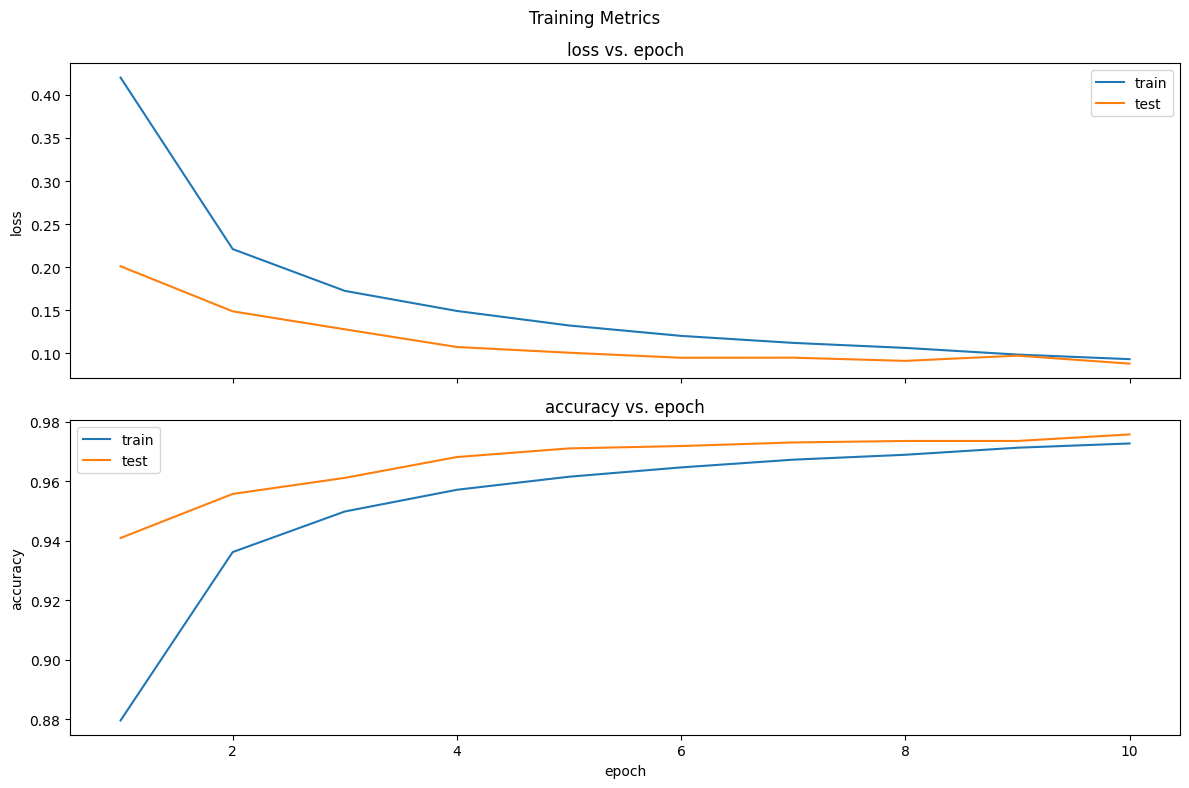

Test: loss=0.09, acc=0.98


In [10]:
import tensorflow as tf
tf.random.set_seed(seed=42)
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("models", exist_ok=True)
checkpoint_path = "models/training.weights.h5"
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    patience=1, factor=0.9)
checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor="test_accuracy",
    mode="max", save_best_only=True, save_weights_only=True,
    filepath=checkpoint_path)
callbacks = tf.keras.callbacks.CallbackList(model=training_model,
    add_history=True, callbacks=[reduce_lr, checkpoint])

logs = {}
history = {
    "train_loss": [], "train_accuracy": [],
    "test_loss": [], "test_accuracy": []
}

callbacks.on_train_begin(logs=logs)
start_time = time.time()
for epoch in range(10):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for x, y in ds_train:
        logs = train_step(model=training_model, x=x, y=y)
    for k, v in logs.items():
        history[k].append(v.numpy())
    for m in training_model.metrics:
        m.reset_state()

    for x, y in ds_test:
        logs = test_step(model=training_model, x=x, y=y)
    for k, v in logs.items():
        history[k].append(v.numpy())
    for m in training_model.metrics:
        m.reset_state()

    callbacks.on_epoch_end(epoch=epoch, logs=logs)
callbacks.on_train_end(logs=logs)
print("Training duration: %2.fs"%(time.time() - start_time))

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
fig.suptitle(t="Training Metrics")
axes[1].set_xlabel(xlabel="epoch")
for ax, m in zip(axes, ["loss", "accuracy"]):
    g = sns.lineplot(ax=ax, data=df_history, label="train",
        x="epoch", y=f"train_{m}")
    g = sns.lineplot(ax=ax, data=df_history, label="test",
        x="epoch", y=f"test_{m}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

training_model.load_weights(checkpoint_path)
loss, acc = training_model.evaluate(x=ds_test, verbose=0)
print(f"Test: loss={loss:.2f}, acc={acc:.2f}")

inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs=inputs, outputs=outputs)

model_path = "models/inference.keras"
inference_model.save(filepath=model_path)

In [11]:
import numpy as np
import tensorflow as tf
tf.random.set_seed(seed=42)

inference_model = tf.keras.models.load_model(
    filepath=model_path)

idx = 79
x_pred = np.reshape(a=x_test[idx], newshape=(1, 28, 28))
y_pred = inference_model(x_pred)
print("y_true:", y_test[idx], "y_pred:", np.argmax(y_pred))

y_true: 7 y_pred: 7
